* Take a single tile and a single recycled plume
* modulate the strength of the plume
* pass it through to a model's inference
* look at detection as a function of plume strength

In [1]:
import datetime
import os
import pathlib

import numpy as np
import rasterio
import torch
import tqdm
from matplotlib import pyplot as plt
from satellite_data_product.sentinel2_legacy.stages.sim_creation.sim_creation_utils import (
    get_gamma,
    sim_radtran,
)

from src.azure_wrap.ml_client_utils import initialize_blob_service_client
from src.data.atmospheric_data import ATMOSPHERIC_DATA
from src.data.recycled_plumes.data_item import OldMultiTemporalPlumesDataItem
from src.data.sentinel2 import SceneClassificationLabel as SCLabel
from src.inference.inference_functions import (
    obtain_data_items_4by4,
    predict,
)
from src.inference.inference_target_location import add_retrieval_to_pred, plot_prediction
from src.plotting.plotting_functions import plot_frac
from src.training.loss_functions import TwoPartLoss
from src.utils.parameters import MAIN_IDX
from src.utils.utils import initialize_clients, load_model_and_concatenator

In [2]:
SC_MASK_LABELS = [
    SCLabel.NO_DATA,
    SCLabel.CLOUD_HIGH_PROBABILITY,
    SCLabel.CLOUD_MEDIUM_PROBABILITY,
]
S2_BANDS = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B09",
    "B11",
    "B12",
    "B8A",
    "SCL",
]

In [3]:
crop_size = 128
# Initialize clients
ml_client, _, _, s3_client = initialize_clients(force_msi=False)
abs_client = initialize_blob_service_client(ml_client)

# Loading a retrieval

In [4]:
# just grab a random plume from the test directory
in_dir = pathlib.Path(os.path.abspath("../test/in/data/recycled_plumes"))
plume_dir = in_dir / "plumes"
plume_files = list(plume_dir.glob("**/*.tiff"))
assert len(plume_files) > 0

plume_file = plume_files[0]
with rasterio.open(plume_file) as plume_ds:
    retrieval = plume_ds.read(1)
    # convert from mol/m2 to mol/cm2 (there are 10,000 cm2 in a m2)
    retrieval /= 10000

In [5]:
retrieval.min()  # there are some negative numbers in the retrieval! wtf?

-0.00011913903127889111

Text(0.5, 1.0, 'A random plume (mol/cm2)')

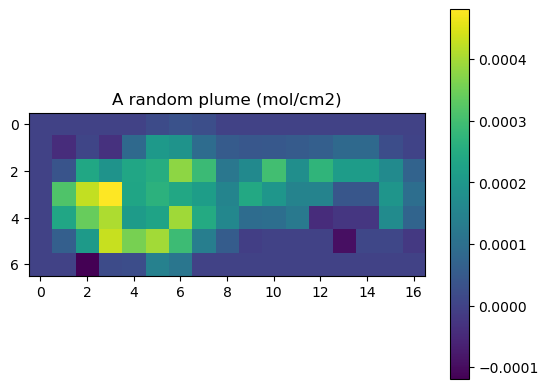

In [6]:
plt.imshow(retrieval)
plt.colorbar()
plt.title("A random plume (mol/cm2)")

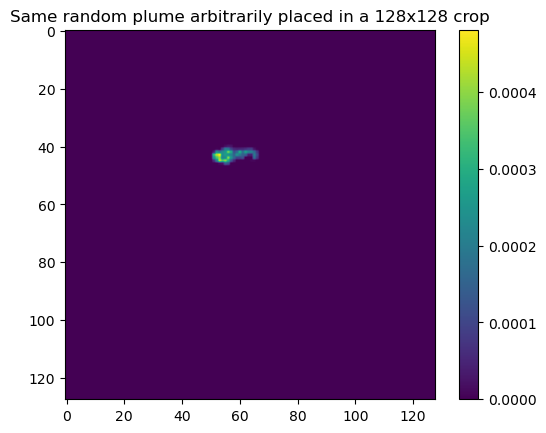

In [7]:
# place the plume somewhere inside of the tile
methane_enhancement_molpercm2 = np.zeros((crop_size, crop_size), dtype=float)
x, y = 40, 50
methane_enhancement_molpercm2[x : x + retrieval.shape[0], y : y + retrieval.shape[1]] = np.where(
    retrieval > 0, retrieval, 0.0
)
plt.imshow(methane_enhancement_molpercm2)
plt.title("Same random plume arbitrarily placed in a 128x128 crop")
plt.colorbar()

# Obtaining S2 data

In [8]:
# load a tile (Conoco-Phillips site, out of interest)
lat, lon = 31.896, -104.032
target_date = datetime.datetime(2024, 5, 14, tzinfo=datetime.timezone.utc)
data_item_generator = obtain_data_items_4by4(
    lat,
    lon,
    start_time=target_date - datetime.timedelta(days=15),
    end_time=target_date + datetime.timedelta(days=15),
    crop_size=crop_size,
    max_cloud_ratio=0.2,
    abs_client=abs_client,
    s3_client=s3_client,
    l1c=False,  # keeping as False since these outputs were generated with L2A
)

In [9]:
data_items = list(data_item_generator)
# the index of the scene nearest the target date
itarget = np.argmin([abs((timestamp - target_date).total_seconds()) for (data_item, timestamp, s2_item) in data_items])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.96s/it]


Dates of S2 items found:
2024-04-29 17:29:01.024000+00:00
2024-05-09 17:29:01.024000+00:00
2024-05-14 17:28:59.024000+00:00
2024-05-19 17:29:01.024000+00:00
2024-05-24 17:28:59.024000+00:00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.30s/it]


In [10]:
methane_free, timestamp, s2_stack = data_items[itarget]

# Adding methane to Sentinel bands

In [11]:
instrument = s2_stack[MAIN_IDX].instrument
gamma = get_gamma(s2_stack[MAIN_IDX].solar_angle, s2_stack[MAIN_IDX].observation_angle)

In [12]:
AVOGADRO_CONSTANT = 6.02214076e23
SIM_SPACING_RESOLUTION = 5000


# TODO: this function should be factored out
def apply_methane_absorption(
    methane_free: OldMultiTemporalPlumesDataItem,
    retrieval: np.ndarray,
    instrument,
    gamma,
    plume_file: pathlib.Path,
    bands: list[str],
    swir16_band_name: str,
    swir22_band_name: str,
) -> OldMultiTemporalPlumesDataItem:
    """
    Take a OldMultiTemporalPlumesDataItem and apply additional absorption in bands 11 and 12 for the concentration of methane specified in `retrieval`.

    This creates a new modified OldMultiTemporalPlumesDataItem.
    """
    index_swir16 = bands.index(swir16_band_name)
    index_swir22 = bands.index(swir22_band_name)

    orig_swir16 = methane_free.orig_swir16
    orig_swir22 = methane_free.orig_swir22

    assert orig_swir16.shape == retrieval.shape
    band_frac_offset = 100.0
    offset_swir16 = orig_swir16 + band_frac_offset
    offset_swir22 = orig_swir22 + band_frac_offset

    # apply radiative transfer
    sim_swir16, sim_swir22 = sim_radtran(
        s2_ref_band=offset_swir16,
        s2_band=offset_swir22,
        **ATMOSPHERIC_DATA[instrument],
        methane_enhancement=retrieval,
        gamma=gamma,
        av_constant=AVOGADRO_CONSTANT,
        spacing_resolution=SIM_SPACING_RESOLUTION,
    )

    # calculate FRAC from the simulated bands
    band_ratio = offset_swir22 / offset_swir16
    sim_band_ratio = sim_swir22 / sim_swir16
    reference_frac = (sim_band_ratio - band_ratio) / band_ratio
    # now remove the offset from the simulated bands and clip to zero
    # (otherwise we're giving the neural network information
    #  that wouldn't actually be present in a real image)
    np.clip(sim_swir16 - band_frac_offset, a_min=0.0, a_max=None, out=sim_swir16)
    np.clip(sim_swir22 - band_frac_offset, a_min=0.0, a_max=None, out=sim_swir22)
    # and also round to the nearest integer, again
    # so the neural network can't use non-integer values
    # as a way to detect methane
    np.round(sim_swir16, decimals=0, out=sim_swir16)
    np.round(sim_swir22, decimals=0, out=sim_swir22)
    # Modify the main crop array's band 11 and 12
    crop_main = methane_free.crop_main.copy()
    crop_main[index_swir16] = sim_swir16
    crop_main[index_swir22] = sim_swir22

    plume_item = OldMultiTemporalPlumesDataItem(
        crop_earlier=methane_free.crop_earlier,
        crop_before=methane_free.crop_before,
        crop_main=crop_main,
        crop_after=methane_free.crop_after,
        orig_swir16=methane_free.orig_swir16,
        orig_swir22=methane_free.orig_swir22,
        target_frac=1 - (1 - methane_free.target_frac) * (1 - reference_frac.astype(np.float32)),
        mask_earlier=methane_free.mask_earlier,
        mask_before=methane_free.mask_before,
        mask_main=methane_free.mask_main,
        mask_after=methane_free.mask_after,
        granule_item_ids=methane_free.granule_item_ids,
        plume_files=[plume_file],
        bands=methane_free.bands,
        size=methane_free.size,
        crop_x=methane_free.crop_x,
        crop_y=methane_free.crop_y,
        main_cloud_ratio=methane_free.main_cloud_ratio,
    )
    return plume_item


def sim_plume_tweaked_retrieval(
    methane_free: OldMultiTemporalPlumesDataItem,
    retrieval,
    tweak: float,
    bands: list[str],
    swir16_band_name: str,
    swir22_band_name: str,
    *args,
    **kwargs,
) -> OldMultiTemporalPlumesDataItem:
    tweaked_retrieval = tweak * retrieval
    return apply_methane_absorption(
        methane_free, tweaked_retrieval, bands, swir16_band_name, swir22_band_name, *args, **kwargs
    )

In [13]:
plume_item = sim_plume_tweaked_retrieval(
    methane_free, methane_enhancement_molpercm2, 1.0, S2_BANDS, "B11", "B12", instrument, gamma, plume_file
)

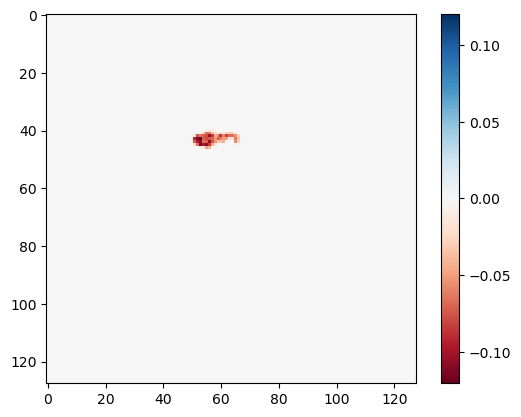

In [14]:
plot_frac(torch.Tensor(plume_item.target_frac))
plt.colorbar()

# Detecting methane with CV model

In [15]:
# load the model from an experiment
# Note: this sometimes gets stuck, it should only take a few seconds
# If that happens, just interrupt the kernel and run the cell again.
# https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-models-mlflow?view=azureml-api-2#loading-models-from-registry

model, band_concatenator, training_params = load_model_and_concatenator("models:/torchgeo_pwr_unet/159", device="cpu")
lossFn = TwoPartLoss(
    binary_threshold=training_params["binary_threshold"], MSE_multiplier=training_params["MSE_multiplier"]
)

2024-09-16 20:34:07 [INFO] Parsing tracking uri /mlflow/v1.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace (utils.py:234)
2024-09-16 20:34:07 [INFO] Tracking uri /mlflow/v1.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace has sub id 6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab, resource group orbio-ml-rg, and workspace orbio-ml-ml-workspace (utils.py:256)
2024-09-16 20:34:07 [INFO] Fetching cloud metadata from known urls (cloud.py:520)
2024-09-16 20:34:07 [INFO] Cloud was fetched from known metadataurls (cloud.py:469)
2024-09-16 20:34:07 [INFO] Cloud metadata not found so falling back to AzureCloud as default (cloud.py:481)
2024-09-16 20:34:07 [INFO] No environment configuration found. (environment.py:115)
2024-09-16 20:34:07 [INFO] ManagedIdentityCredential will use Azure ML mana

In [16]:
pred_dict = predict(
    model=model, device="cpu", band_concatenator=band_concatenator, recycled_item=plume_item, lossFn=lossFn
)
# NOTE: predict stores the 4D arrays for each prediction. We squeeze in the plotting fns where necessary

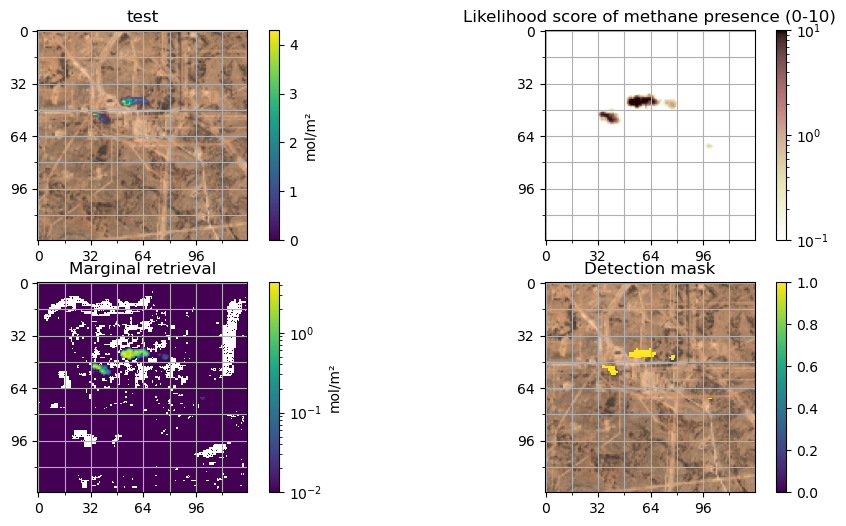

In [17]:
plt.figure(figsize=(12, 6))
# NOTE: it seems like plot_prediction requires the retrieval to be added to pred_dict. So we run that fn first
main_s2_item = s2_stack[MAIN_IDX]
pred = add_retrieval_to_pred(pred_dict, main_s2_item)
plot_prediction(pred, "test")

# Repeating with tweaked methane strength

In [18]:
# This is the core of the notebook, where we modulate
# the strength of the plume and get a prediction (inference)
# from the neural network.
# We then look at the "binary probability" layer of the prediction,
# averaged over the ground truth mask (pixels that contain methane)
ground_truth_mask = methane_enhancement_molpercm2 > 1e-9

tweak_arr = np.logspace(-1.5, 0.0, 30)
tweaked_items = [
    sim_plume_tweaked_retrieval(
        methane_free, methane_enhancement_molpercm2, tweak, S2_BANDS, "B11", "B12", instrument, gamma, plume_file
    )
    for tweak in tqdm.tqdm(tweak_arr)
]
min_frac = np.array([abs(t.target_frac.min()) for t in tweaked_items])
max_tweaked_retrieval = methane_enhancement_molpercm2.max() * 10000 * tweak_arr
tweaked_pred = [predict(model, "cpu", band_concatenator, tweaked, lossFn) for tweaked in tweaked_items]

### extract some statistics from the predictions ###
mean_prob_of_tweaked_pred_in_mask = np.array(
    [np.mean(pred["binary_probability"].numpy(), where=ground_truth_mask) for pred in tweaked_pred]
)

max_prob_of_tweaked_pred_in_mask = np.array(
    [np.max(pred["binary_probability"].numpy(), where=ground_truth_mask, initial=0.0) for pred in tweaked_pred]
)

sum_marginal_of_tweaked_pred_in_mask = np.array(
    [np.mean(pred["marginal_pred"].numpy(), where=ground_truth_mask) for pred in tweaked_pred]
)

sum_conditional_of_tweaked_pred_in_mask = np.array(
    [np.mean(pred["conditional_pred"].numpy(), where=ground_truth_mask) for pred in tweaked_pred]
)

sum_tweaked_frac_in_mask = np.array([np.mean(t.target_frac, where=ground_truth_mask) for t in tweaked_items])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:35<00:00,  1.18s/it]


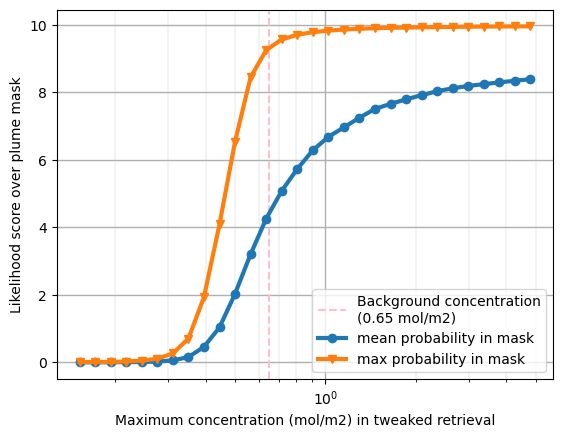

In [19]:
plt.axvline(0.65, color="pink", linestyle="--", label="Background concentration\n(0.65 mol/m2)")
plt.plot(
    max_tweaked_retrieval, mean_prob_of_tweaked_pred_in_mask * 10, "o-", linewidth=3, label="mean probability in mask"
)
plt.plot(
    max_tweaked_retrieval, max_prob_of_tweaked_pred_in_mask * 10, "v-", linewidth=3, label="max probability in mask"
)
plt.xscale("log")
plt.xlabel("Maximum concentration (mol/m2) in tweaked retrieval")
plt.ylabel("Likelihood score over plume mask")
plt.legend(loc="lower right")
plt.grid(which="major", linewidth=1.0)
plt.grid(which="minor", linewidth=0.2)

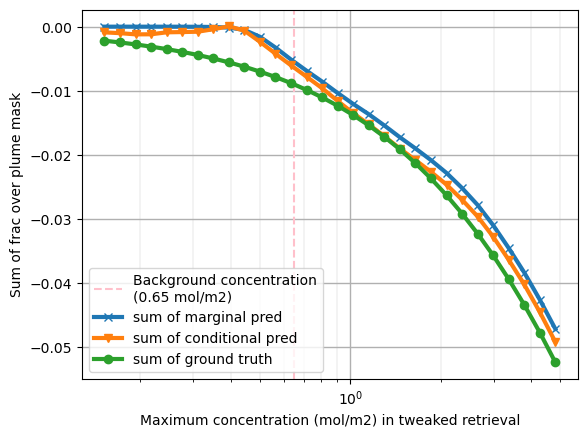

In [20]:
plt.axvline(0.65, color="pink", linestyle="--", label="Background concentration\n(0.65 mol/m2)")
plt.plot(max_tweaked_retrieval, sum_marginal_of_tweaked_pred_in_mask, "x-", linewidth=3, label="sum of marginal pred")
plt.plot(
    max_tweaked_retrieval, sum_conditional_of_tweaked_pred_in_mask, "v-", linewidth=3, label="sum of conditional pred"
)
plt.plot(max_tweaked_retrieval, sum_tweaked_frac_in_mask, "o-", linewidth=3, label="sum of ground truth")
plt.xscale("log")
plt.xlabel("Maximum concentration (mol/m2) in tweaked retrieval")
plt.ylabel("Sum of frac over plume mask")
plt.legend(loc="lower left")
plt.grid(which="major", linewidth=1.0)
plt.grid(which="minor", linewidth=0.2)

Text(-0.02, -0.04, 'Overestimate\nmethane')

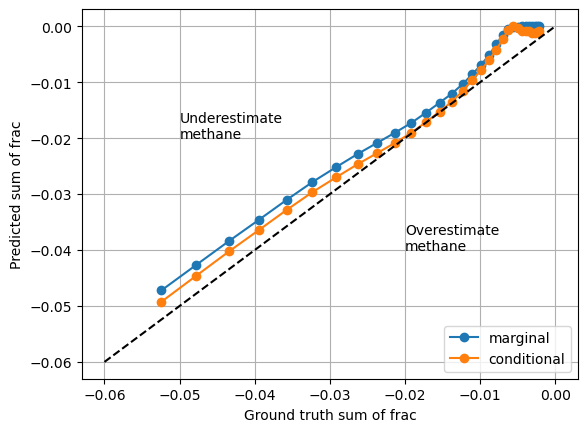

In [21]:
plt.plot(sum_tweaked_frac_in_mask, sum_marginal_of_tweaked_pred_in_mask, "o-", label="marginal")
plt.plot(sum_tweaked_frac_in_mask, sum_conditional_of_tweaked_pred_in_mask, "o-", label="conditional")
plt.grid()
plt.plot((-0.06, 0), (-0.06, 0), color="black", linestyle="--")
plt.xlabel("Ground truth sum of frac")
plt.ylabel("Predicted sum of frac")
plt.legend(loc="lower right")
plt.text(-0.05, -0.02, "Underestimate\nmethane")
plt.text(-0.02, -0.04, "Overestimate\nmethane")

**Conclusion with model models:/torchgeo_pwr_unet/70**

This experiment shows a smooth increase in the binary probability output by the neural network as the recycled plume gets stronger and stronger.
The detection starts at a concentration of about 0.6 mol/m2, which is roughly the background concentration of methane in the atmosphere.
It reaches 5/10 at about 2 mol/m2, which is a Hassi-like concentration.
What this would mean is that this neural network is not yet very good at detecting weak plumes.

In terms of detection strength, we see that overall the prediction strength tracks the true strength (sum of ground truth frac), but with a significant discrepancy.
The plume strength is first underestimated and then overestimated as the concentration increases.

**Update with model models:/torchgeo_pwr_unet/159**

The detection threshold has improved significantly, with detection starting at about 0.4 mol/m2, below the background concentration of methane in the atmosphere.
It reaches 5/10 at 0.7 mol/m2, just above the background.
The predicted strength also tracks the true strength much closer.

In [22]:
# maximum methane concentration in plume
methane_enhancement_molpercm2.max() * 10000
# 4.8 mol/m2
# This is actually very high! Varon 2020 Hassi detections go up to about 2 mol/m2

4.809929159048774

# Histogram of maximum retrieval

In [23]:
import random

In [24]:
Texas2019_dir = os.path.expanduser("~/localfiles/data/orbio-data-exports/usa_v2.2.0/2019/Texas/meta_data")
Texas2019_plumes = os.listdir(Texas2019_dir)

In [25]:
sample_plume_files = random.sample(Texas2019_plumes, 1000)

In [26]:
max_retrieval = []
for f in sample_plume_files:
    with rasterio.open(os.path.join(Texas2019_dir, f)) as plume_ds:
        retrieval = plume_ds.read(1)
        max_retrieval.append(retrieval.max())
max_retrieval = np.array(max_retrieval)

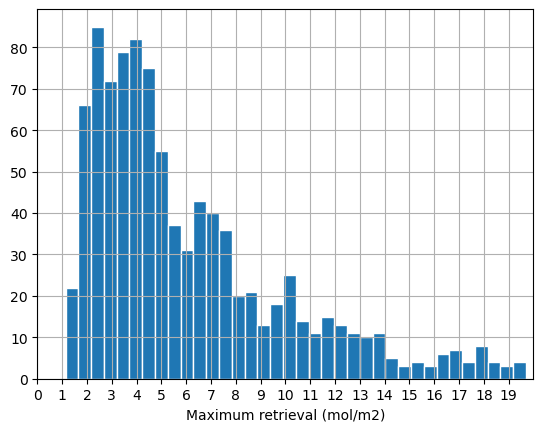

In [27]:
plt.hist(max_retrieval, bins=100, edgecolor="white")
plt.xlabel("Maximum retrieval (mol/m2)")
plt.xticks(range(20))
plt.xlim(0, 20)
plt.grid()

In [28]:
# percentage of plumes with a maximum retrieval above 4 mol/m2
np.mean(max_retrieval > 4) * 100

63.2

The data does not actually contain weaker sources.
The smallest ones are 1.15 mol/m2, which is almost double the background methane concentration of 0.65 mol/m2.
More than 60% of plumes have a max retrieval above 4 mol/m2, which is enormous (off the scale in Varon's plots).
It may be that we simply need better representation of weak sources in the training data in order for the neural network to learn to detect them.